# Text feature extraction: representing text as numerical data

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

- **tokenizing** strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
- **counting** the occurrences of tokens in each document.
- **normalizing** and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Methods we will learn:

1. **Bag of words**
2. **TF-IDF**
3. **Binary representation**

### 1. The Bag of Words representation

In this scheme, features and samples are defined as follows:
- each individual token occurrence frequency (normalized or not) is treated as a feature.
- the vector of all the token frequencies for a given document is considered a multivariate sample.

This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

`CountVectorizer` implements both tokenization and occurrence counting in a single class:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
vectorizer = CountVectorizer()
vectorizer

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In general (not only with bag of words) there are 2 steps to produce a vector representation for each document:
   1. Learn the vocubulary in the corpus: this done using the `fit` method.
   2. Use that vocabulary to produce the vector representation for each document: this is done using the `transform` method.
   
Scikit learn provides the `fit_transform` method to perfom the 2 steps at the same time.

In [7]:
corpus = [
          'This is the first document.',
          'This is the second second document.',
          'And the third one. Yes, yes, yes this',
          'Is this the first document?'
         ]

In [8]:
# step1: learn the 'vocabulary' of the training data (occurs in-place)
vectorizer.fit(corpus)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
# examine the fitted vocabulary (tokens)
vectorizer.get_feature_names()

[u'and',
 u'document',
 u'first',
 u'is',
 u'one',
 u'second',
 u'the',
 u'third',
 u'this',
 u'yes']

In [10]:
# step 2: Vectorize the documents (dtm: document-token matrix)
X_dtm = vectorizer.transform(corpus)

**Sparcity**
As most documents will typically use a very small subset of the words used in the corpus, the resulting matrix will have many feature values that are zeros (typically more than 99% of them).

For instance a collection of 10,000 short text documents (such as emails) will use a vocabulary with a size in the order of 100,000 unique words in total while each document will use 100 to 1000 unique words individually.
In order to be able to store such a matrix in memory but also to speed up algebraic operations matrix / vector, implementations will typically use a sparse representation such as the implementations available in the `scipy.sparse` package.

In [11]:
# Representation of a sparse matrix
print X_dtm

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 6)	1
  (0, 8)	1
  (1, 1)	1
  (1, 3)	1
  (1, 5)	2
  (1, 6)	1
  (1, 8)	1
  (2, 0)	1
  (2, 4)	1
  (2, 6)	1
  (2, 7)	1
  (2, 8)	1
  (2, 9)	3
  (3, 1)	1
  (3, 2)	1
  (3, 3)	1
  (3, 6)	1
  (3, 8)	1


In [12]:
X_dtm.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 2, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 1, 3],
       [0, 1, 1, 1, 0, 0, 1, 0, 1, 0]], dtype=int64)

In [13]:
# Bag of words representation
pd.DataFrame(data=X_dtm.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(4)])

,and,document,first,is,one,second,the,third,this,yes
doc_1,0,1,1,1,0,0,1,0,1,0
doc_2,0,1,0,1,0,2,1,0,1,0
doc_3,1,0,0,0,1,0,1,1,1,3
doc_4,0,1,1,1,0,0,1,0,1,0


The converse mapping from feature name to column index is stored in the vocabulary_ attribute of the vectorizer:

In [27]:
print vectorizer.vocabulary_.get('and')
print vectorizer.vocabulary_.get('yes')

0
9


In [31]:
print vectorizer.vocabulary_

{u'and': 0, u'third': 7, u'this': 8, u'is': 3, u'one': 4, u'second': 5, u'the': 6, u'document': 1, u'yes': 9, u'first': 2}


Now the vectorizer object has been "trained" with the vocabulary from the corpus. Hence words that were not seen in the training corpus will be completely ignored in future calls to the transform method:

In [15]:
vectorizer.transform(['this is my second, yes']).toarray()

array([[0, 0, 0, 1, 0, 1, 0, 0, 1, 1]], dtype=int64)

Note that in the previous corpus, the first and the last documents have exactly the same words hence are encoded in equal vectors. In particular we lose the information that the last document is an interrogative form.

In [16]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b|,')
## The two steps can be done with one call to the fit_transform method
X2_dtm = bigram_vectorizer.fit_transform(corpus)
X2_dtm

<4x27 sparse matrix of type '<type 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [17]:
for x in bigram_vectorizer.get_feature_names():
    print x, ' ** ',

,  **  , yes  **  and  **  and the  **  document  **  first  **  first document  **  is  **  is the  **  is this  **  one  **  one yes  **  second  **  second document  **  second second  **  the  **  the first  **  the second  **  the third  **  third  **  third one  **  this  **  this is  **  this the  **  yes  **  yes ,  **  yes this  ** 


In [18]:
pd.DataFrame(data=X2_dtm.toarray(), columns=bigram_vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(4)])

,",",", yes",and,and the,document,first,first document,is,is the,is this,...,the second,the third,third,third one,this,this is,this the,yes,"yes ,",yes this
doc_1,0,0,0,0,1,1,1,1,1,0,...,0,0,0,0,1,1,0,0,0,0
doc_2,0,0,0,0,1,0,0,1,1,0,...,1,0,0,0,1,1,0,0,0,0
doc_3,2,2,1,1,0,0,0,0,0,0,...,0,1,1,1,1,0,0,3,2,1
doc_4,0,0,0,0,1,1,1,1,0,1,...,0,0,0,0,1,0,1,0,0,0


### 2. Tf–idf term weighting

In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.
In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

**tf–idf** means **term-frequency times inverse document-frequency**.

td-idf is intended to reflect how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document, but is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

In [20]:
# it takes a count matrix to a normalized tf or tf-idf representation
tfidf_transformer = TfidfTransformer(smooth_idf=True)
tfidf = tfidf_transformer.fit_transform(X_dtm)
tfidf

<4x10 sparse matrix of type '<type 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [21]:
tfidf_df = pd.DataFrame(data=tfidf.toarray(), columns=vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(4)])
tfidf_df

,and,document,first,is,one,second,the,third,this,yes
doc_1,0.000000,0.453491,0.560151,0.453491,0.000000,0.000000,0.370758,0.000000,0.370758,0.000000
doc_2,0.000000,0.275712,0.000000,0.275712,0.000000,0.863912,0.225413,0.000000,0.225413,0.000000
doc_3,0.282339,0.000000,0.000000,0.000000,0.282339,0.000000,0.147336,0.282339,0.147336,0.847017
doc_4,0.000000,0.453491,0.560151,0.453491,0.000000,0.000000,0.370758,0.000000,0.370758,0.000000


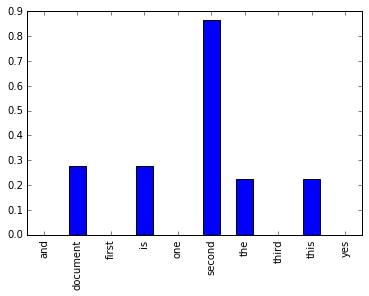

In [22]:
tfidf_df.loc['doc_2'].plot(kind='bar');

### Binary representation

While the tf–idf normalization is often very useful, there might be cases where the binary occurrence markers might offer better features. This can be achieved by using the `binary` parameter of `CountVectorizer`.

In [23]:
binary_vectorizer = CountVectorizer(binary=True)
X_binary = binary_vectorizer.fit_transform(corpus)
X_binary.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1, 0]], dtype=int64)

In [24]:
# Binary representation
pd.DataFrame(data=X_binary.toarray(), columns=binary_vectorizer.get_feature_names(), index=['doc_'+str(i+1) for i in range(4)])

,and,document,first,is,one,second,the,third,this,yes
doc_1,0,1,1,1,0,0,1,0,1,0
doc_2,0,1,0,1,0,1,1,0,1,0
doc_3,1,0,0,0,1,0,1,1,1,1
doc_4,0,1,1,1,0,0,1,0,1,0
